# Inefficient photon detection: Mixing stochastic and deterministic master equations

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from qutip import *
from qutip.expect import expect_rho_vec

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.size'] = '14'

## Direct photo-detection

Here we follow an example from Wiseman and Milburn, *Quantum measurement and control*, section. 4.8.1.

Consider cavity that leaks photons with a rate $\kappa$. The dissipated photons are detected with an inefficient photon detector,
with photon-detection efficiency $\eta$. The master equation describing this scenario, where a separate dissipation channel has been added for detections and missed detections, is

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$

To describe the photon measurement stochastically, we can unravelling only the dissipation term that corresponds to detections, and leaving the missed detections as a deterministic dissipation term, we obtain [Eq. (4.235) in W&M]

$d\rho = \mathcal{H}[-iH -\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

or

$d\rho = -i[H, \rho] dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt -\mathcal{H}[\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

where

$\displaystyle \mathcal{G}[A] \rho = \frac{A\rho A^\dagger}{\mathrm{Tr}[A\rho A^\dagger]} - \rho$

$\displaystyle \mathcal{H}[A] \rho = A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho $

and $dN(t)$ is a Poisson distributed increment with $E[dN(t)] = \eta \langle a^\dagger a\rangle (t)$.

### Formulation in QuTiP

In QuTiP, the photocurrent stochastic master equation is written in the form:

$\displaystyle d\rho(t) = -i[H, \rho] dt + \mathcal{D}[B] \rho dt 
- \frac{1}{2}\mathcal{H}[A^\dagger A] \rho(t) dt 
+ \mathcal{G}[A]\rho(t) d\xi$

where the first two term gives the deterministic master equation (Lindblad form with collapse operator $B$ (c_ops)) and $A$ the stochastic collapse operator (sc_ops). 

Here $A = \sqrt{\eta\gamma} a$ and $B = \sqrt{(1-\eta)\gamma} $a.

In [6]:
N = 15
w0 = 0.5 * 2 * np.pi
times = np.linspace(0, 15, 150)
dt = times[1] - times[0]
gamma = 0.1

In [7]:
a = destroy(N)

In [8]:
H = w0 * a.dag() * a

In [9]:
rho0 = fock(N, 5)

In [10]:
e_ops = [a.dag() * a, a + a.dag()]

### Highly efficient detection

In [11]:
eta = 0.7
c_ops = [np.sqrt(1-eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]   # stochastic collapse operator A

In [12]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [13]:
result1 = photocurrent_mesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                   ntraj=1, nsubsteps=100,  store_measurement=True)

Total run time:   1.22s


In [14]:
result2 = photocurrent_mesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                   ntraj=10, nsubsteps=100,  store_measurement=True)

10.0%. Run time:   1.64s. Est. time left: 00:00:00:14
20.0%. Run time:   3.66s. Est. time left: 00:00:00:14
30.0%. Run time:   5.50s. Est. time left: 00:00:00:12
40.0%. Run time:   7.16s. Est. time left: 00:00:00:10
50.0%. Run time:   9.53s. Est. time left: 00:00:00:09
60.0%. Run time:  11.08s. Est. time left: 00:00:00:07
70.0%. Run time:  12.43s. Est. time left: 00:00:00:05
80.0%. Run time:  14.05s. Est. time left: 00:00:00:03
90.0%. Run time:  15.81s. Est. time left: 00:00:00:01
Total run time:  17.52s


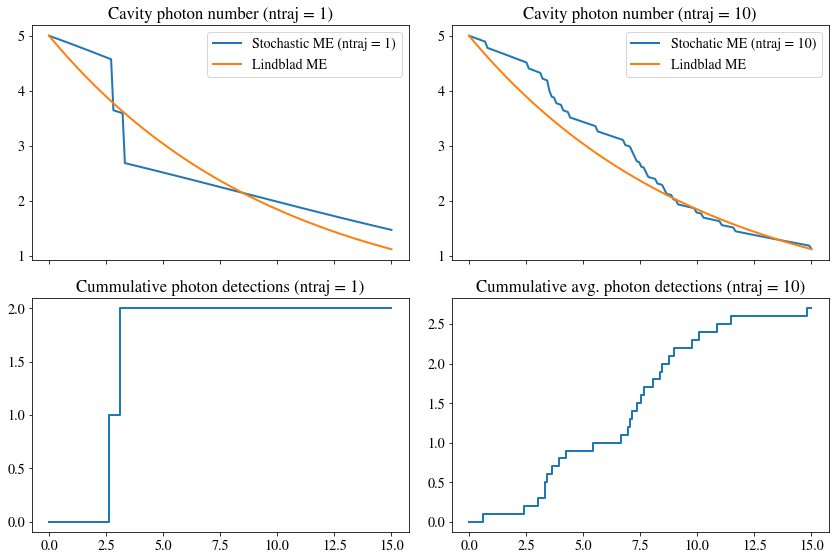

In [15]:
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)

axes[0,0].plot(times, result1.expect[0], label=r'Stochastic ME (ntraj = 1)', lw=2)
axes[0,0].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,0].set_title("Cavity photon number (ntraj = 1)")
axes[0,0].legend()

axes[0,1].plot(times, result2.expect[0], label=r'Stochatic ME (ntraj = 10)', lw=2)
axes[0,1].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,1].set_title("Cavity photon number (ntraj = 10)")
axes[0,1].legend()

axes[1,0].step(times, dt * np.cumsum(result1.measurement[0].real), lw=2)
axes[1,0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1,1].step(times, dt * np.cumsum(np.array(result2.measurement).sum(axis=0).real) / 10, lw=2)
axes[1,1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

### Highly inefficient photon detection

In [16]:
eta = 0.1
c_ops = [np.sqrt(1-eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]   # stochastic collapse operator A

In [17]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [18]:
result1 = photocurrent_mesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                   ntraj=1, nsubsteps=100,  store_measurement=True)

Total run time:   2.02s


In [19]:
result2 = photocurrent_mesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                   ntraj=10, nsubsteps=100,  store_measurement=True)

10.0%. Run time:   1.90s. Est. time left: 00:00:00:17
20.0%. Run time:   3.15s. Est. time left: 00:00:00:12
30.0%. Run time:   4.02s. Est. time left: 00:00:00:09
40.0%. Run time:   5.06s. Est. time left: 00:00:00:07
50.0%. Run time:   6.68s. Est. time left: 00:00:00:06
60.0%. Run time:   8.26s. Est. time left: 00:00:00:05
70.0%. Run time:   9.78s. Est. time left: 00:00:00:04
80.0%. Run time:  11.29s. Est. time left: 00:00:00:02
90.0%. Run time:  12.80s. Est. time left: 00:00:00:01
Total run time:  14.29s


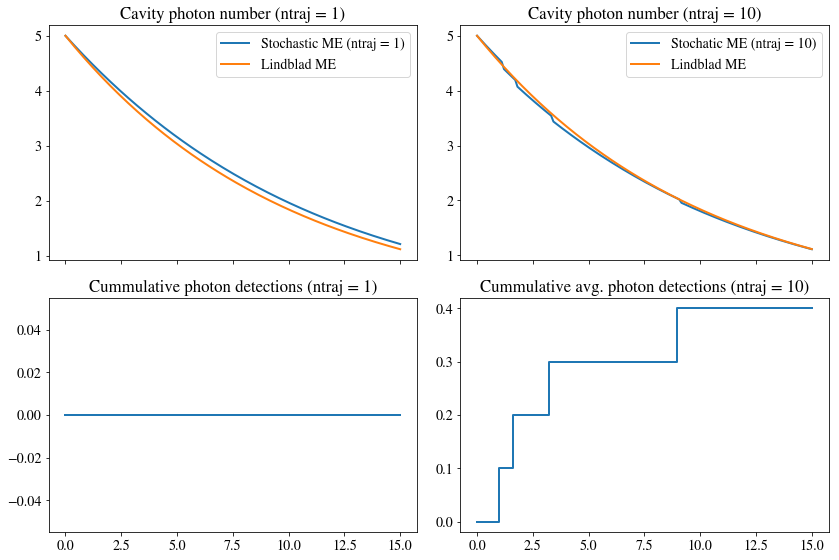

In [20]:
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)

axes[0,0].plot(times, result1.expect[0], label=r'Stochastic ME (ntraj = 1)', lw=2)
axes[0,0].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,0].set_title("Cavity photon number (ntraj = 1)")
axes[0,0].legend()

axes[0,1].plot(times, result2.expect[0], label=r'Stochatic ME (ntraj = 10)', lw=2)
axes[0,1].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,1].set_title("Cavity photon number (ntraj = 10)")
axes[0,1].legend()

axes[1,0].step(times, dt * np.cumsum(result1.measurement[0].real), lw=2)
axes[1,0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1,1].step(times, dt * np.cumsum(np.array(result2.measurement).sum(axis=0).real) / 10, lw=2)
axes[1,1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

## Efficient homodyne detection

The stochastic master equation for inefficient homodyne detection, when unravaling the detection part of the master equation

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$,

is given in W&M as

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] \rho dt 
+
\mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a] \rho dt
+
\mathcal{H}[\sqrt{\eta} \sqrt{\kappa}a] \rho d\xi$

where $d\xi$ is the Wiener increment. This can be described as a standard homodyne detection with efficiency $\eta$ together with a stochastic dissipation process with collapse operator $\sqrt{(1-\eta)\kappa} a$. Alternatively we can combine the two deterministic terms on standard Lindblad for and obtain the stochastic equation (which is the form given in W&M)

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{\kappa} a]\rho dt + \sqrt{\eta}\mathcal{H}[\sqrt{\kappa}a] \rho d\xi$

Below we solve these two equivalent equations with QuTiP

In [21]:
rho0 = coherent(N, np.sqrt(5))

### Form 1: Standard homodyne with deterministic dissipation on Lindblad form

In [22]:
eta = 0.95
c_ops = [np.sqrt(1-eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]   # stochastic collapse operator A

In [23]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [24]:
result = smesolve(H, rho0, times, c_ops, sc_ops, e_ops, ntraj=75, nsubsteps=100, solver="platen",
                  method='homodyne', store_measurement=True, map_func=parallel_map, noise=111)

10.7%. Run time:  27.01s. Est. time left: 00:00:03:46
20.0%. Run time:  50.10s. Est. time left: 00:00:03:20
30.7%. Run time:  68.35s. Est. time left: 00:00:02:34
40.0%. Run time:  86.92s. Est. time left: 00:00:02:10
50.7%. Run time: 109.52s. Est. time left: 00:00:01:46
60.0%. Run time: 128.93s. Est. time left: 00:00:01:25
70.7%. Run time: 149.73s. Est. time left: 00:00:01:02
80.0%. Run time: 173.65s. Est. time left: 00:00:00:43
90.7%. Run time: 199.11s. Est. time left: 00:00:00:20
100.0%. Run time: 227.05s. Est. time left: 00:00:00:00
Total run time: 227.09s


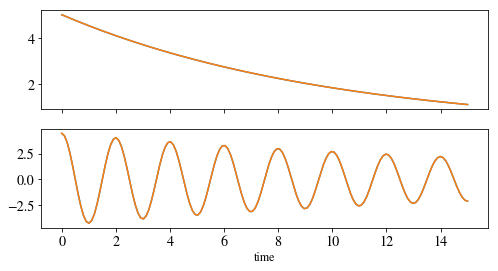

In [25]:
plot_expectation_values([result, result_ref]);

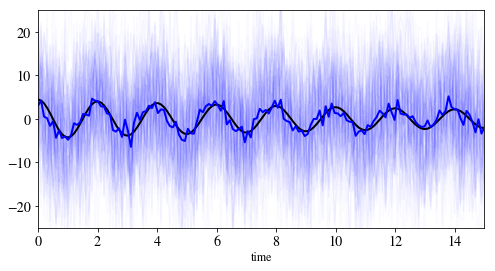

In [26]:
fig, ax = plt.subplots(figsize=(8,4))

M = np.sqrt(eta * gamma)

for m in result.measurement:
    ax.plot(times, m[:, 0].real / M, 'b', alpha=0.025)

ax.plot(times, result_ref.expect[1], 'k', lw=2);

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real / M, 'b', lw=2);

### Form 2: Combined homodyne with deterministic dissipation for missed detection events

$\displaystyle D_{1}[A]\rho(t) = \mathcal{D}[\kappa a]\rho(t) = \mathcal{D}[A]\rho(t)$

In [27]:
L = liouvillian(H, np.sqrt(gamma) * a)
def d1_rho_func(t, rho_vec):
    return L * rho_vec

$\displaystyle D_{2}[A]\rho(t) = \sqrt{\eta} \mathcal{H}[\sqrt{\kappa} a]\rho(t) = \sqrt{\eta} \mathcal{H}[A]\rho(t) 
= \sqrt{\eta}(A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho)
\rightarrow \sqrt{\eta} \left((A_L +  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L +  A_R^\dagger)\rho_v] \rho_v\right)$

In [28]:
n_sum = spre(np.sqrt(gamma) * a) + spost(np.sqrt(gamma) * a.dag())
def d2_rho_func(t, rho_vec):
    e1 = expect_rho_vec(n_sum.data, rho_vec, False)
    return np.vstack([np.sqrt(eta) * (n_sum * rho_vec - e1 * rho_vec)])

In [29]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [30]:
result = general_stochastic(ket2dm(rho0), times, e_ops=[spre(op) for op in e_ops], 
                  ntraj=75, nsubsteps=100, solver="platen",
                  d1=d1_rho_func, d2=d2_rho_func, len_d2=1,
                  m_ops=[spre(a + a.dag())], dW_factors=[1/np.sqrt(gamma * eta)],
                  store_measurement=True, map_func=parallel_map, noise=111)

10.7%. Run time: 121.70s. Est. time left: 00:00:16:59
20.0%. Run time: 178.67s. Est. time left: 00:00:11:54
30.7%. Run time: 238.98s. Est. time left: 00:00:09:00
40.0%. Run time: 300.75s. Est. time left: 00:00:07:31
50.7%. Run time: 384.11s. Est. time left: 00:00:06:14
60.0%. Run time: 447.18s. Est. time left: 00:00:04:58
70.7%. Run time: 524.70s. Est. time left: 00:00:03:37
80.0%. Run time: 587.57s. Est. time left: 00:00:02:26
90.7%. Run time: 668.02s. Est. time left: 00:00:01:08
100.0%. Run time: 738.23s. Est. time left: 00:00:00:00
Total run time: 738.28s


(<Figure size 576x288 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43d95178d0>],
       dtype=object))

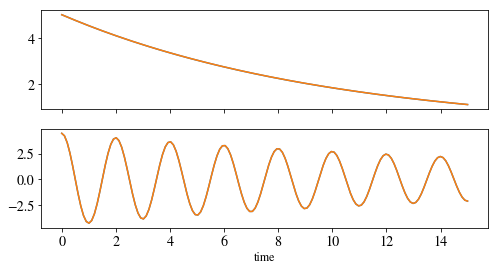

In [31]:
plot_expectation_values([result, result_ref])

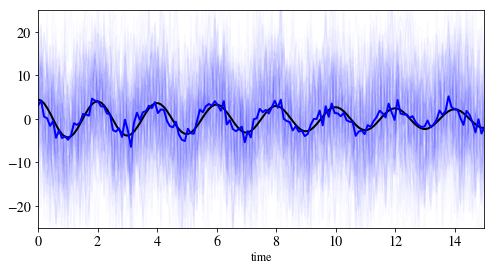

In [32]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, 'b', alpha=0.025)

ax.plot(times, result_ref.expect[1], 'k', lw=2);

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real, 'b', lw=2);

## Versions

In [33]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.0.dev0+ea5344d9
Numpy,1.16.0
SciPy,1.2.0
matplotlib,3.0.2
Cython,0.29.3
Number of CPUs,1
BLAS Info,OPENBLAS
IPython,7.2.0
Python,"3.6.7 (default, Oct 22 2018, 11:32:17) [GCC 8.2.0]"
OS,posix [linux]
